# Run Segment Anything Model 2 on a live video stream


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display
import networkx as nx
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import re

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 camera predictor


In [3]:
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint) # in multiple object tracking we have initialise interference state

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_bbox(bbox, ax, marker_size=200):
    tl, br = bbox[0], bbox[1]
    w, h = (br - tl)[0], (br - tl)[1]
    x, y = tl[0], tl[1]
    print(x, y, w, h)
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=None, edgecolor="blue", linewidth=2))

In [5]:
def gen_out_mask_logits_ids(ann_frame_idx=0, ann_obj_id=1, points=None,  bbox=None, mask=None, labels=None):
    if points is not None:
        if labels is None:
            raise ValueError("Labels must be provided if points are given.")
        else:
            _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
                frame_idx=ann_frame_idx,
                obj_id=ann_obj_id,
                points=points,
                labels=labels,
            )
            # show_points(points, labels, plt.gca())

    elif bbox is not None:
        # TODO need to add multiple prompt per track
        _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
            frame_idx=ann_frame_idx, obj_id=ann_obj_id, bbox=bbox)
        # show_bbox(bbox, plt.gca())

    elif mask is not None:
        # mask_img_path="masks/aquarium/aquarium_mask.png"
        # mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
        # mask = mask / 255
        assert mask.max() <= 1 , "Masks should be in [0, 1] range."
        _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
            frame_idx=ann_frame_idx, obj_id=ann_obj_id, mask=mask
        )
        # show_mask(out_mask_logits, plt.gca(), obj_id=ann_obj_id, random_color=True)
    else:
        raise ValueError("At least one of points, bbox, or mask must be provided.")
    
    return out_obj_ids, out_mask_logits

#### Select an video stream (video or camera)


In [6]:
cap = cv2.VideoCapture("videos/aquarium/aquarium.mp4")
cap = cv2.VideoCapture("/scratch3/kat049/datasets/DARPA/p14_fr/camera0-1024x768-002.mp4")
ret, frame = cap.read()
width, height = frame.shape[:2][::-1]

start_idx = 1148
vis_gap = 30
video_dir = "/scratch3/kat049/datasets/DARPA/p14_fr/results" #args.video_path
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(p[len("frame"):].split('.')[0]))
frame_names = frame_names[start_idx:-1:vis_gap]
frame = Image.open(os.path.join(video_dir, frame_names[0])) #image_pil
frame_RGB = np.array(frame) #image_rgb
frame_BGR = frame_RGB[:, :, ::-1]  # image
width, height = frame.size[0], frame.size[1]

#### Step 1: Add a first click on the first frame


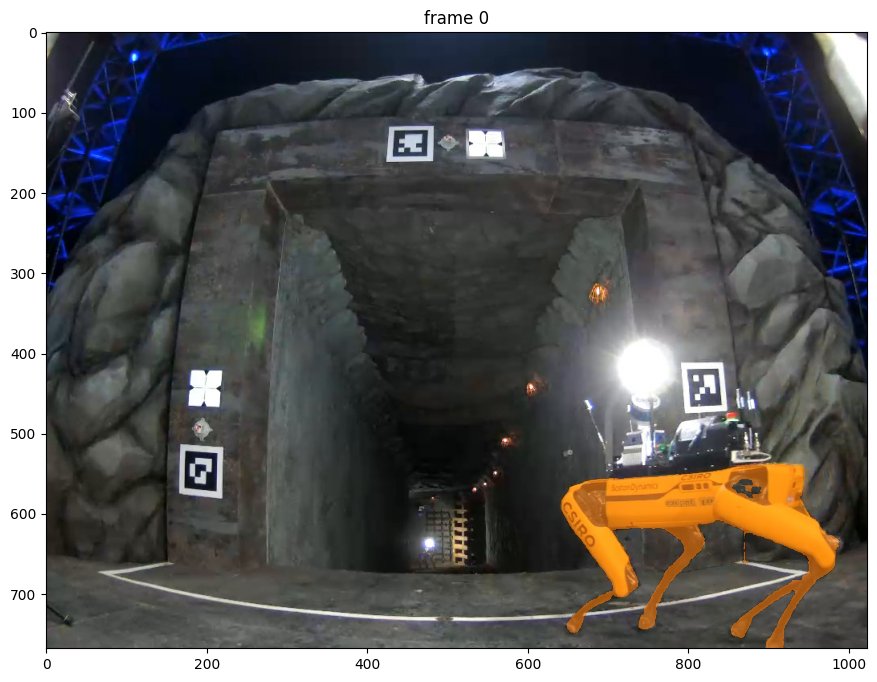

In [7]:
predictor.load_first_frame(frame_BGR)
# if_init = True

# using_point = False # if True, we use point prompt
# using_box = True # if True, we use point prompt
# using_mask= False  # if True, we use mask prompt

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    1  # give a unique id to each object we interact with (it can be any integers)
)
# Let's add a positive click at (x, y) = (210, 350) to get started

# using point prompt
points = np.array([[670, 247]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], dtype=np.int32)
bbox = np.array([[600, 214], [765, 286]], dtype=np.float32)
bbox = np.array([[440, 580], [500, 680]], dtype=np.float32)
bbox1 = np.array([[620, 540], [980, 800]], dtype=np.float32)
# bbox2 = np.array([[160, 510], [220, 580]], dtype=np.float32)


# # TODO need to implement multiple prompt per track
# bboxes = [bbox1, bbox2]
# for ann_obj_id in range(2):
#     print(f"Adding prompt for object {ann_obj_id+1} in frame {ann_frame_idx} with bbox {bboxes[ann_obj_id]}")
#     # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize=(12, 8))
#     plt.title(f"frame {ann_frame_idx}")
#     plt.imshow(frame_RGB)
#     bbox = bboxes[ann_obj_id]
#     out_obj_ids, out_mask_logits = gen_out_mask_logits_ids(
#         ann_frame_idx=ann_frame_idx,
#         ann_obj_id=ann_obj_id+1,
#         points=None,
#         labels=None,
#         bbox=bbox,
#         mask=None,
#     )
#     show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id+1)
#     plt.show()
#     plt.close()

# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame_RGB)
out_obj_ids, out_mask_logits = gen_out_mask_logits_ids(
    ann_frame_idx=ann_frame_idx,
    ann_obj_id=ann_obj_id,
    points=None,
    labels=None,
    bbox=bbox1,
    mask=None,
)
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)
plt.show()


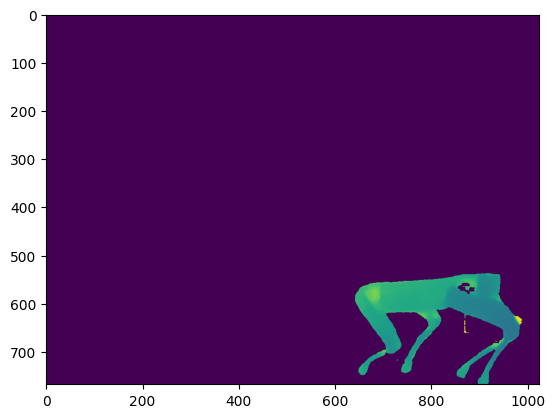

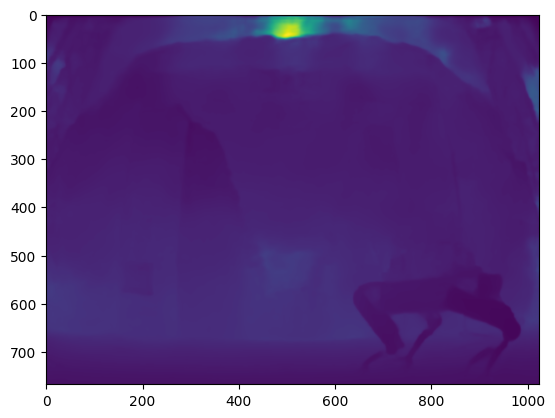

5.5566872775532365

In [8]:
# depth_names = [
#     p for p in os.listdir(video_dir)
#     if os.path.splitext(p)[-1] in [".png"]
# ]
# depth_names.sort(key=lambda p: int(p[len("depth"):].split('.')[0]))
# depth_names = depth_names[start_idx:-1:vis_gap]

depth_frame = Image.open(os.path.join(video_dir, re.sub(r'frame(\d+)\.jpg', r'depth\1.png', frame_names[0]))) #image_pil
depth_frame = np.array(depth_frame)

mask = (out_mask_logits.squeeze() > 0).cpu().numpy()  # Shape: (768, 1024)
masked_depth_image = depth_frame * mask  # Shape: (768, 1024)
masked_depths = depth_frame[mask]
plt.imshow(masked_depth_image)
plt.show()
plt.imshow(depth_frame)
plt.show()
mean_depth = np.mean(masked_depths)/1000 # Convert to meters
mean_depth

In [9]:
# get the masked image
def get_masked_image(frame_RGB, mask):
    if not (mask==True).any():
        print("No mask found, skipping frame")
        return None
    # masked_image = torch.tensor(frame_RGB.copy(), device="cuda").permute(2, 0, 1)  # [3, 360, 800]
    # masked_rgb_image = frame_RGB * mask[..., None] 
    # bbox = bbox1
    # x_min, y_min = int(bbox[0][0]), int(bbox[0][1])
    # x_max, y_max = int(bbox[1][0]), int(bbox[1][1])
    # x_min = max(0, min(x_min, width-1))
    # y_min = max(0, min(y_min, height-1))
    # x_max = max(0, min(x_max, width-1))
    # y_max = max(0, min(y_max, height-1))
    # bbox_region = masked_image[:, y_min:y_max, x_min:x_max]
    # bbox_region_np = bbox_region.permute(1, 2, 0).cpu().numpy()

    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]

    # Crop both RGB and mask to bounding box
    cropped_rgb = frame_RGB[y_min:y_max+1, x_min:x_max+1]
    cropped_mask = mask[y_min:y_max+1, x_min:x_max+1]

    masked_rgb_cropped = cropped_rgb * cropped_mask[:, :, None]
    # plt.imshow(masked_rgb_cropped)
    return masked_rgb_cropped

In [10]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation
import os

def load_data_files(rgb_file_path, pose_file_path):
    """
    Load and parse the two data files
    
    Args:
        rgb_file_path: Path to RGB timestamp file
        pose_file_path: Path to pose data file
    
    Returns:
        rgb_df: DataFrame with columns ['timestamp', 'filename']
        pose_df: DataFrame with columns ['timestamp', 'x', 'y', 'z', 'qw', 'qx', 'qy', 'qz']
    """
    # Load RGB file
    rgb_df = pd.read_csv(rgb_file_path, sep=' ', header=None, 
                        names=['timestamp', 'rgb_path'])
    rgb_df['filename'] = rgb_df['rgb_path'].apply(lambda x: os.path.basename(x))
    
    # Load pose file  
    pose_df = pd.read_csv(pose_file_path, sep=' ', header=None,
                         names=['timestamp', 'x', 'y', 'z', 'qw', 'qx', 'qy', 'qz'])
    
    return rgb_df, pose_df

rgb_df, pose_df = load_data_files(
    "/scratch3/kat049/VSLAM-LAB-Benchmark/DARPA/p14_fr_2/rgb.txt",
    "/scratch3/kat049/VSLAM-LAB-Benchmark/DARPA/p14_fr_2/groundtruth.txt"
)

def find_closest_pose(timestamp, pose_df):
    """
    Find the pose entry with closest timestamp
    
    Args:
        timestamp: Target timestamp
        pose_df: DataFrame with pose data
    
    Returns:
        Series with closest pose data
    """
    time_diffs = np.abs(pose_df['timestamp'] - timestamp)
    closest_idx = time_diffs.idxmin()
    return pose_df.loc[closest_idx]

def quaternion_to_rotation_matrix(qw, qx, qy, qz):
    """Convert quaternion to rotation matrix using scipy"""
    # Note: scipy uses [x, y, z, w] format
    quat = [qx, qy, qz, qw]
    r = Rotation.from_quat(quat)
    return r.as_matrix()

def calculate_motion_between_frames(frame1_name, frame2_name, rgb_df, pose_df):
    """
    Calculate motion between two frames
    
    Args:
        frame1_name: First frame filename (e.g., 'frame00001.jpg')
        frame2_name: Second frame filename (e.g., 'frame00002.jpg')
        rgb_df: RGB timestamp DataFrame
        pose_df: Pose timestamp DataFrame
    
    Returns:
        dict: Motion information including translation, rotation, and distances
    """
    # Find timestamps for both frames
    frame1_row = rgb_df[rgb_df['filename'] == frame1_name]
    frame2_row = rgb_df[rgb_df['filename'] == frame2_name]
    
    if frame1_row.empty:
        raise ValueError(f"Frame {frame1_name} not found in RGB data")
    if frame2_row.empty:
        raise ValueError(f"Frame {frame2_name} not found in RGB data")
    
    timestamp1 = frame1_row.iloc[0]['timestamp']
    timestamp2 = frame2_row.iloc[0]['timestamp']
    
    # Find closest poses
    pose1 = find_closest_pose(timestamp1, pose_df)
    pose2 = find_closest_pose(timestamp2, pose_df)
    
    # Calculate translation
    pos1 = np.array([pose1['x'], pose1['y'], pose1['z']])
    pos2 = np.array([pose2['x'], pose2['y'], pose2['z']])
    translation = pos2 - pos1
    
    # Calculate rotation
    R1 = quaternion_to_rotation_matrix(pose1['qw'], pose1['qx'], pose1['qy'], pose1['qz'])
    R2 = quaternion_to_rotation_matrix(pose2['qw'], pose2['qx'], pose2['qy'], pose2['qz'])
    
    # Relative rotation from frame1 to frame2
    R_relative = R2 @ R1.T
    
    # Convert back to quaternion and angle-axis
    r_relative = Rotation.from_matrix(R_relative)
    quat_relative = r_relative.as_quat()  # [x, y, z, w]
    angle_axis = r_relative.as_rotvec()
    rotation_angle = np.linalg.norm(angle_axis)  # in radians
    
    # Calculate distances
    euclidean_distance = np.linalg.norm(translation)
    
    # Time differences
    time_diff = timestamp2 - timestamp1
    pose_time_diff1 = abs(timestamp1 - pose1['timestamp'])
    pose_time_diff2 = abs(timestamp2 - pose2['timestamp'])
    
    return {
        'frame1': frame1_name,
        'frame2': frame2_name,
        'timestamp1': timestamp1,
        'timestamp2': timestamp2,
        'time_difference': time_diff,
        'pose_time_diff1': pose_time_diff1,
        'pose_time_diff2': pose_time_diff2,
        'translation': translation,
        'translation_magnitude': euclidean_distance,
        'rotation_matrix': R_relative,
        'rotation_quaternion': quat_relative,  # [x, y, z, w]
        'rotation_angle_rad': rotation_angle,
        'rotation_angle_deg': np.degrees(rotation_angle),
        'position1': pos1,
        'position2': pos2,
        'velocity': translation / time_diff if time_diff != 0 else np.zeros(3),
        'angular_velocity': angle_axis / time_diff if time_diff != 0 else np.zeros(3)
    }

file_prev = frame_names[0]
# np.square(calculate_motion_between_frames(file_prev, frame_names[20], rgb_df, pose_df)['translation']).sum() ** 0.5

In [11]:
def get_relative_distance2obj(image_file, mask):
    try:
        depth_frame = Image.open(os.path.join(video_dir, re.sub(r'frame(\d+)\.jpg', r'depth\1.png', image_file))) #image_pil
    except FileNotFoundError:
        print(f"Depth file for {image_file} not found.")
        # TODO convert RGB to depth
        return None
    
    depth_frame = np.array(depth_frame)

    # masked_depth_image = depth_frame * mask # Shape: (h, w)
    masked_depths = depth_frame[mask]  # Extract depths where mask is True
    # plt.imshow(masked_depth_image)
    # plt.show()
    # plt.imshow(depth_frame)
    # plt.show()
    mean_depth = np.mean(masked_depths)/1000 # Convert to meters
    return mean_depth

# get_relative_distance2obj(frame_names[0], mask)

In [12]:
def create_mixed_graph(image_node, rel_distance):
    """Create a graph with mixed node types"""
    G = nx.Graph()
    
    # Add nodes with different types
    G.add_node("text1", type="text", content="Self", pos=(0, 0))
    G.add_node("mask1", type="mask", content=image_node, pos=(1, 1))
    
    # Add edges
    G.add_edges_from([
        ("text1", "mask1", {"weight": rel_distance}),
    ])
    
    return G

def visualize_mixed_graph(G, ax):
    """Visualize graph with text and image nodes"""    
    # Get positions
    pos = nx.get_node_attributes(G, 'pos')

    # Draw edges with weights
    edges = G.edges(data=True)
    edge_weights = [d.get('weight', 1.0) for u, v, d in edges]
    
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=2)
    
    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d.get('weight', 1.0):.1f}" for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, ax=ax, font_size=8)
    
    # Process each node
    for node, (x, y) in pos.items():
        node_data = G.nodes[node]
        
        if node_data['type'] == 'text':
            # Draw text nodes as boxes
            bbox = dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.8)
            ax.text(x, y, node_data['content'], ha='center', va='center', 
                   fontsize=12, bbox=bbox, weight='bold')
                   
        elif node_data['type'] == 'mask':
            # Draw mask nodes as images
            mask_img = node_data['content']
            # Handle different mask formats
            if len(mask_img.shape) == 2:
                # Grayscale mask [h, w] -> RGB
                mask_rgb = cv2.cvtColor(mask_img, cv2.COLOR_GRAY2RGB)
            elif mask_img.shape[2] == 3:
                # Already RGB [h, w, 3]
                mask_rgb = mask_img
            else:
                # Handle other cases (like RGBA)
                mask_rgb = mask_img[:, :, :3]
                
            # Create OffsetImage
            imagebox = OffsetImage(mask_rgb, zoom=0.5)
            ab = AnnotationBbox(imagebox, (x, y), frameon=True, pad=0.1)
            ax.add_artist(ab)
    
    # ax.set_xlim(-1, 3)
    # ax.set_ylim(-2, 2)
    # ax.set_aspect('equal')
    # ax.set_title('Graph at time', fontsize=14, weight='bold')
    ax.axis('off')
    
    # plt.tight_layout()
    # return ax

G_temporal = []
connect_Gs = []
G = create_mixed_graph(get_masked_image(frame_RGB, mask),mean_depth)
G_temporal.append(G)

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 8))
# visualize_mixed_graph(G, ax)
# plt.show()
# plt.close(fig)
file_prev = frame_names[0]
for i, file in enumerate(frame_names[1:]):
    frame = Image.open(os.path.join(video_dir, file)) #image_pil
    frame_RGB = np.array(frame) #image_rgb
    frame_BGR = frame_RGB[:, :, ::-1]  # image

    out_obj_ids, out_mask_logits = predictor.track(frame_BGR)
    mask = (out_mask_logits.squeeze() > 0).cpu().numpy()  # Shape: (768, 1024)
    
    mean_depth = get_relative_distance2obj(file, mask)
    # print(mean_depth)
    masked_rgb_cropped = get_masked_image(frame_RGB, mask)
    if masked_rgb_cropped is None:
        print(f"Skipping frame {i} due to no mask found.")
        continue
    # plt.imshow(masked_rgb_cropped)
    rel_motion = np.square(calculate_motion_between_frames(file_prev, file, rgb_df, pose_df)['translation']).sum() ** 0.5
    if rel_motion > 0.05: # moved more than 5 cm
        connect_Gs.append(rel_motion)
        break
    else:
        connect_Gs.append(0.0)
    file_prev = file
    G = create_mixed_graph(masked_rgb_cropped,mean_depth)
    G_temporal.append(G)
    # fig, ax = plt.subplots(figsize=(12, 8))
    # visualize_mixed_graph(G, ax)
    # plt.show()
    # plt.close(fig)

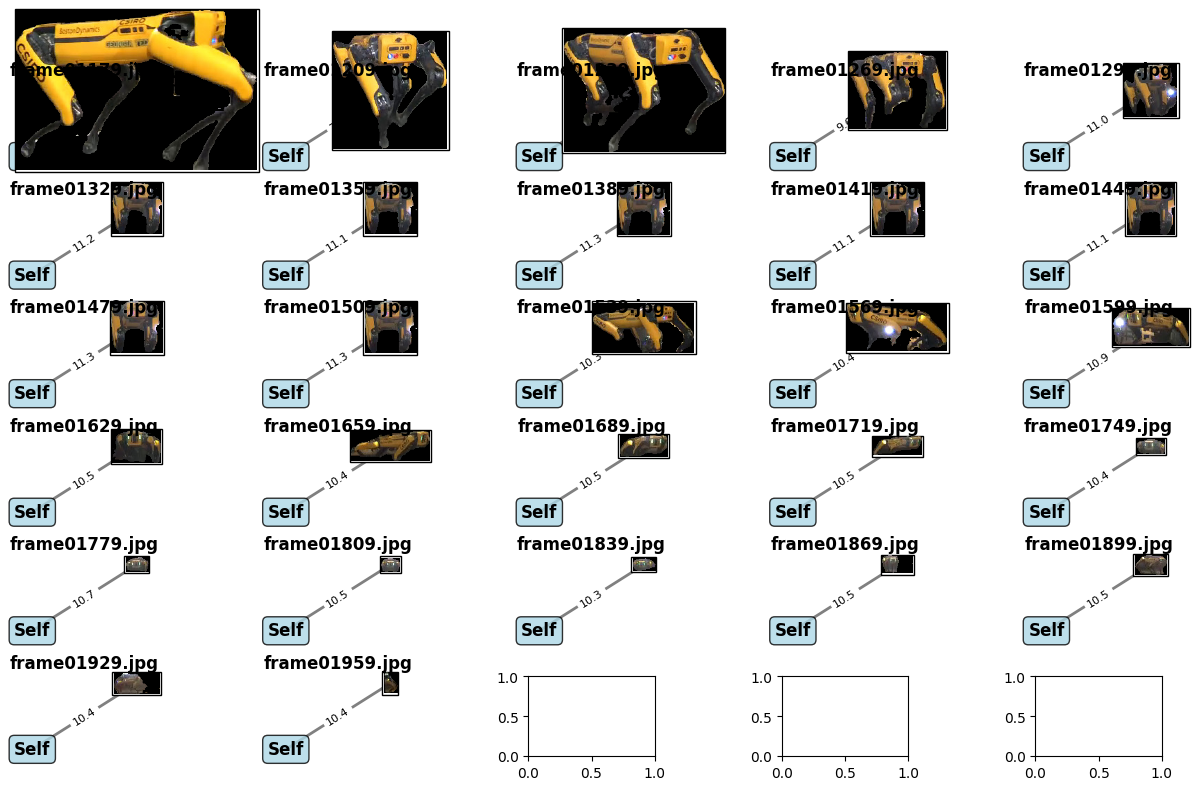

In [14]:
fig, axes  = plt.subplots(6, 5, figsize=(12, 8))
ax_iter = iter(axes.flat)


for i, g in enumerate(G_temporal):
    file = frame_names[1:][i]
    try:
        ax = next(ax_iter)
        visualize_mixed_graph(g, ax=ax)
        ax.set_title(f'{file}', fontsize=12, weight='bold')
    except StopIteration:
        print(f"Warning: More graphs ({len(G_temporal)}) than subplots (12)")
        break

# Hide unused subplots
for j in range(i+1, 12):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()